# <p style="color:#C4D300; text-align:center;"><strong>__Shrek Work__</strong></p>

### *New Packages*

In [11]:
#%pip install matplotlib

In [12]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install wordcloud matplotlib

Note: you may need to restart the kernel to use updated packages.


### *Imports*

In [14]:
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx

## <p style="color:#74B72E; text-align:center"><strong>__Working Functions__</strong></p>

In [ ]:
def get_unique_characters(config):
    path = config["file_path"]["path"]
    name_pattern = config["file_path"]["name_pattern"]
    characters = set()

    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            match = re.match(name_pattern, line)
            if match:
                characters.add(match.group(1).strip())

    return sorted(characters)

In [ ]:
def get_character_word_counts(config):
    """
    Reads a script file, looks for lines that match the specified name_pattern,
    extracts the character name, and counts the words spoken by that character.
    
    Args:
        config (dict): A dictionary containing:
            - config["file_path"]["path"]: Path to the processed text file.
            - config["file_path"]["movie_name"]: Name of the movie (optional usage).
            - config["file_path"]["name_pattern"]: Regex pattern to capture the character name.
    
    Returns:
        dict: A dictionary where keys are character names and values are total words spoken.
    """
    file_path = config["file_path"]["path"]
    name_pattern = re.compile(config["file_path"]["name_pattern"])
    character_counts = {}

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            # Look for lines matching your name pattern, e.g. "SHREK:"
            match = name_pattern.match(line)
            if match:
                character_name = match.group(1).strip()

                # Remove the matched portion (e.g., "SHREK:") to isolate the dialogue
                spoken_text = line[len(match.group(0)):]
                words = spoken_text.split()
                character_counts[character_name] = character_counts.get(character_name, 0) + len(words)

    return character_counts

# Now just call the function using the config you already loaded
counts = get_character_word_counts(shrek2_config)
print(counts)

In [ ]:
counts = get_character_word_counts(shrek2_config)
print(counts)

## <p style="color:#74B72E; text-align:center"><strong>__Main Class__</strong></p>

In [16]:
class CharacterAnalysis:
    def __init__(
        self,
        config,
        character_list=False,
        word_count=False,
        pie_chart=False,
        word_cloud=False,
        character_specific=None
    ):
        """
        Parses a script and provides character-based analysis, leveraging the 
        logic from 'get_word_counts'. It accounts for:
          - Exclusions (lines to skip)
          - Multi-line dialogue (all lines after character name get attributed 
            until a new character name is seen)
          - Optional character-specific queries

        Parameters:
        -----------
        config : dict
          Expected structure:
            {
              "file_path": {
                "path":          str  # e.g. "data/shrek2_script.txt",
                "movie_name":    str  # e.g. "Shrek 2",
                "name_pattern":  str  # e.g. r"^([\w\s']+):"
              },
              "exclusions": [
                [regex_str, description],
                [regex_str, description],
                ...
              ]
            }

        character_list : bool
          If True, displays the names of all characters found in the script.

        word_count : bool
          If True, displays the word count (and dialogue count) for all characters 
          or a single character if 'character_specific' is provided.

        pie_chart : bool
          If True, displays a pie chart of word counts for either all characters 
          or a single character.

        word_cloud : bool
          If True, displays a word cloud for either the entire script or 
          the specified character.

        character_specific : str
          If provided, only data for the matching character (case-insensitive) 
          is displayed/analyzed.
        """

        self.config = config
        self.file_path = self.config["file_path"]["path"]
        self.movie_name = self.config["file_path"]["movie_name"]
        self.name_pattern = re.compile(self.config["file_path"]["name_pattern"])
        self.exclusion_patterns = [
            re.compile(pattern) for pattern, _ in self.config.get("exclusions", [])
        ]

        # Core data structures
        self.word_count_dict = defaultdict(int)       # total words per character
        self.dialogue_count_dict = defaultdict(int)   # how many times each character "starts to speak"
        self.character_dialogues = defaultdict(list)  # all lines for each character

        # We'll build a sorted list (results) after parsing
        self.results = []

        # Parse the script (leveraging logic from your 'get_word_counts')
        self._parse_script()

        # Build a sorted list of characters by descending word count
        self._build_results()

        # Handle character-specific if requested
        if character_specific:
            # Find canonical key (case-insensitive match)
            found_key = self._find_character_key(character_specific)
            if not found_key:
                print(f"No dialogue found for character: {character_specific}")
                return
            character_specific = found_key

        # Conditionally display outputs
        if character_list and not character_specific:
            self._display_character_list()

        if word_count:
            self._display_word_counts(character_specific)

        if pie_chart:
            self._display_pie_chart(character_specific)

        if word_cloud:
            self._display_word_cloud(character_specific)

        if character_specific:
            self._display_character_lines(character_specific)

    def _parse_script(self):
        """
        Reads the script line by line, skipping any that match exclusion patterns,
        and attributing dialogue to the last matched character name.
        """
        current_character = None

        with open(self.file_path, 'r', encoding='utf-8') as file:
            for line in file:
                line = line.strip()

                # Skip lines that match any exclusion regex
                if any(excl.match(line) for excl in self.exclusion_patterns):
                    continue

                # Check if line matches character name pattern
                match = self.name_pattern.match(line)
                if match:
                    # Found a new character
                    current_character = match.group(1).strip()

                    # Count words on same line after the colon
                    # e.g. "SHREK: Hey now I'm an ogre."
                    if ":" in line:
                        # Everything after first colon is the same line's dialogue
                        dialogue_part = line.split(":", 1)[1].strip()
                        self.word_count_dict[current_character] += len(dialogue_part.split())
                        self.character_dialogues[current_character].append(dialogue_part)

                    # Bump the "dialogue count" for this new speaking block
                    self.dialogue_count_dict[current_character] += 1

                elif current_character:
                    # Not a new character line, but we have an active speaker
                    words_in_line = line.split()
                    self.word_count_dict[current_character] += len(words_in_line)
                    self.character_dialogues[current_character].append(line)

    def _build_results(self):
        """
        Builds a sorted list of results from the dictionaries, 
        ordered by descending word count.
        """
        self.results = sorted(
            [
                {
                    "Character": char,
                    "Dialogue Count": self.dialogue_count_dict[char],
                    "Word Count": self.word_count_dict[char],
                }
                for char in self.word_count_dict
            ],
            key=lambda x: x["Word Count"],
            reverse=True
        )

    def _display_character_list(self):
        """
        Prints an alphabetically-sorted list of discovered characters.
        """
        characters = sorted(self.word_count_dict.keys())
        print(f"\nCharacters in '{self.movie_name}':")
        for char in characters:
            print(f" - {char}")

    def _display_word_counts(self, character_specific):
        """
        Prints word counts (and dialogue counts) either for all characters 
        or for a single specified character.
        """
        if character_specific:
            # Just the one character
            print(f"\n[{character_specific}]")
            print(f" - Dialogue Count: {self.dialogue_count_dict[character_specific]}")
            print(f" - Word Count: {self.word_count_dict[character_specific]}")
        else:
            # Everyone
            print(f"\n[Dialogue & Word Counts for '{self.movie_name}']")
            for stat in self.results:
                print(
                    f"{stat['Character']}: "
                    f"Dialogue Count = {stat['Dialogue Count']}, "
                    f"Word Count = {stat['Word Count']}"
                )

    def _display_pie_chart(self, character_specific):
        """
        Displays a pie chart of word counts. If character_specific is set, 
        shows only that character's slice.
        """
        if character_specific:
            count = self.word_count_dict[character_specific]
            plt.figure(figsize=(6, 6))
            plt.pie([count], labels=[character_specific], autopct="%1.1f%%")
            plt.title(f"'{character_specific}' Word Count")
            plt.show()
        else:
            labels = [stat["Character"] for stat in self.results]
            sizes = [stat["Word Count"] for stat in self.results]
            plt.figure(figsize=(10, 8))
            plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
            plt.title(f"Word Count Distribution in '{self.movie_name}'")
            plt.show()

    def _display_word_cloud(self, character_specific):
        """
        Displays a word cloud for either a single character or for everyone.
        """
        if character_specific:
            all_text = " ".join(self.character_dialogues[character_specific])
            wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"{character_specific} - Word Cloud")
            plt.show()
        else:
            combined_text = []
            for char, lines in self.character_dialogues.items():
                combined_text.extend(lines)
            wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(combined_text))
            plt.figure(figsize=(10, 5))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"{self.movie_name} - Word Cloud")
            plt.show()

    def _display_character_lines(self, character):
        """
        Prints all lines attributed to a specified character.
        """
        if character not in self.character_dialogues:
            print(f"No lines found for '{character}'")
            return

        print(f"\nLines spoken by '{character}':")
        for line in self.character_dialogues[character]:
            print(line)

    def _find_character_key(self, char_name):
        """
        Attempts to find a character by name (case-insensitive). 
        Returns the matched key if found, else None.
        """
        target = char_name.lower()
        for known_char in self.word_count_dict:
            if known_char.lower() == target:
                return known_char
        return None


<>:11: SyntaxWarning: invalid escape sequence '\w'
<>:11: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_2698/203977131.py:11: SyntaxWarning: invalid escape sequence '\w'
  """


## <p style="color:#ffdb00; text-align:center;"><strong>__Bee Movie__</strong></p>

In [ ]:
bee_movie_config = {
    "file_path": {
        "path": "data/bee_script.txt",     # Path to the script
        "movie_name": "Bee Movie",         # Movie name for printing
        "name_pattern": r'^([A-Z ]+):'     # Regex to match character names in all caps before a colon
    },
    "exclusions": [
        (r'\(.*?\)', 'text inside parentheses'),        # Exclude text inside parentheses
        (r'^[A-Z ]+:', 'character names in all caps'),  # Exclude character names in all caps
    ]
}

In [ ]:
CharacterAnalysis(
    bee_movie_config,
    character_list=False,
    word_count=False,
    pie_chart=False,
    word_cloud=True,
    character_specific=False
);

## <p style="color:#C4D300; text-align:center;"><strong>__Shrek 2__</strong></p>

### <p style="color:#C4D300; "><strong>__Pre-Process File__</strong></p>

In [ ]:
def process_script_file(input_file_path, output_file_path):
    """
    Reads a script file, removes bracketed text (including multiline),
    removes lines starting with EXT or INT (ignoring leading spaces, case-insensitive),
    writes the cleaned text to an output file, and prints word count stats.

    Args:
        input_file_path (str): Path to the input text file.
        output_file_path (str): Path to the output text file.

    Returns:
        None
    """

    # Step 1: Read in the entire file and count words before processing
    with open(input_file_path, "r", encoding="utf-8") as f:
        original_text = f.read()

    word_count_before = len(original_text.split())
    print(f"Word Count Before Processing: {word_count_before}")

    # Step 2: Remove everything inside brackets [ ... ], even if it spans multiple lines
    text_no_brackets = re.sub(r"\[.*?\]", "", original_text, flags=re.DOTALL)

    # Step 3: Remove lines that start with ENT or INT (case-insensitive, ignoring leading spaces)
    lines = text_no_brackets.splitlines()
    processed_lines = []
    for line in lines:
        # If a line starts (after optional whitespace) with EXT or INT, skip it
        if re.match(r"^\s*(EXT|INT)", line, re.IGNORECASE):
            continue
        processed_lines.append(line)

    # Join the remaining lines back into a single string
    cleaned_text = "\n".join(processed_lines)

    # Step 4: Write processed text to a new file
    with open(output_file_path, "w", encoding="utf-8") as f:
        f.write(cleaned_text)

    # Step 5: Count words after processing
    word_count_after = len(cleaned_text.split())
    print(f"Word Count After Processing: {word_count_after}")

    print(f"File processed and saved as '{output_file_path}'.")

# Example of how you might call it:
process_script_file("data/shrek2_script.txt", "data/P_shrek.txt")

### <p style="color:#C4D300; "><strong>__Process File__</strong></p>

In [17]:
shrek2_config = {
    "file_path": {
        "path": "data/processed_file.txt",
        "movie_name": "Shrek 2",
        "name_pattern": r'^([\w\s\']+):'  # e.g. "SHREK:" or "Prince Charming:"
    }
}


[Dialogue & Word Counts for 'Shrek 2']
Donkey: Dialogue Count = 159, Word Count = 1701
Shrek: Dialogue Count = 215, Word Count = 1520
Fairy Godmother: Dialogue Count = 84, Word Count = 1042
King Harold: Dialogue Count = 84, Word Count = 865
Puss in Boots: Dialogue Count = 61, Word Count = 691
Fiona: Dialogue Count = 92, Word Count = 561
Prince Charming: Dialogue Count = 31, Word Count = 396
Queen Lillian: Dialogue Count = 34, Word Count = 270
Gingy: Dialogue Count = 24, Word Count = 129
Jill: Dialogue Count = 8, Word Count = 77
Announcer: Dialogue Count = 4, Word Count = 69
Joan: Dialogue Count = 5, Word Count = 67
Doris: Dialogue Count = 7, Word Count = 65
Page: Dialogue Count = 3, Word Count = 54
Pinocchio: Dialogue Count = 14, Word Count = 53
Jerome: Dialogue Count = 7, Word Count = 52
Mongo: Dialogue Count = 4, Word Count = 39
Narrator: Dialogue Count = 3, Word Count = 37
PRICILLA: Dialogue Count = 3, Word Count = 24
Knight: Dialogue Count = 4, Word Count = 18
Magic Mirror: Dialog

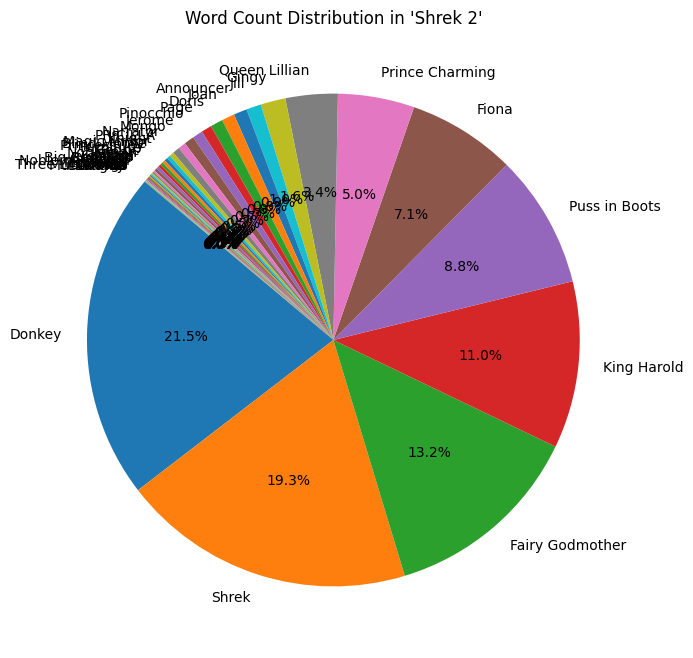

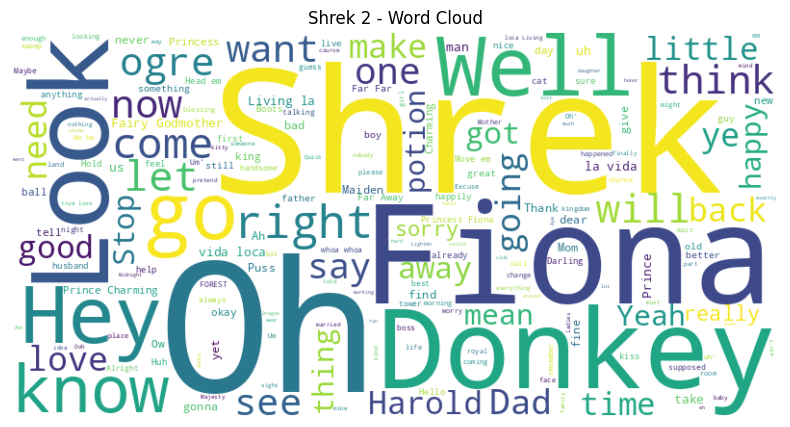

In [20]:
analysis = CharacterAnalysis(
    config=shrek2_config,
    character_specific=False,  # or "SHREK" or "shrek" etc.
    word_count=True,
    pie_chart=True,
    word_cloud=True
)